In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils 
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
PROPHET_PATH = '../data/prophet/'
DATA_PATH = '../data/'
RESULTS_PATH = 'results/'

In [10]:
train = pd.read_csv(DATA_PATH+'train_2.csv')

In [11]:
train2 = train.iloc[:,1:]

In [12]:
page_df = train.loc[:,['Page']].reset_index()
page_df.columns = ['page_index', 'Page']; page_df.head()

,page_index,Page
0,0,2NE1_zh.wikipedia.org_all-access_spider
1,1,2PM_zh.wikipedia.org_all-access_spider
2,2,3C_zh.wikipedia.org_all-access_spider
3,3,4minute_zh.wikipedia.org_all-access_spider
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...


# Final_median_pred

In [14]:
train2 = train2.iloc[:,::-1]

In [32]:
def smape_dataframe(median_preds, train_start, val_length):
    denominator = train2.iloc[:,train_start-val_length:train_start].add(median_preds, axis=0) / 200
    diff = np.abs(train2.iloc[:,train_start-val_length:train_start].subtract(median_preds, axis=0)) / denominator
    diff[denominator == 0] = 0.0
    return diff.mean(axis=1, skipna=True)

In [38]:
def calc_median_preds(start):  
    return np.nan_to_num(np.round(
        np.nanmedian(
        train2.iloc[:,start:].values[:,:49], axis=1)).reshape(-1,1)).astype(int)

In [44]:
np.nan_to_num(np.round(
                        np.nanmedian(
                        train.drop('Page', axis=1).values[:, -49:], axis=1)).reshape(-1,1)).astype(int)

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


array([[22],
       [19],
       [ 3],
       ..., 
       [10],
       [ 4],
       [ 3]])

In [40]:
page_df['preds'] = calc_median_preds(60)

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [47]:
val_length = 60
for train_start in range(val_length, train2.shape[1]-49, val_length): # -49 because need this much length to calc median properly
    page_df['preds'] = calc_median_preds(train_start)
    page_df['start'+str(train_start)] = smape_dataframe(page_df['preds'], train_start, val_length)
    

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [56]:
smape_results = page_df.iloc[:,3:]

In [57]:
smape_results.shape

(145063, 12)

In [59]:
smape_results.head()

,start60,start120,start180,start240,start300,start360,start420,start480,start540,start600,start660,start720
0,32.278432,25.959053,38.466197,53.353312,42.962347,40.581529,45.425883,30.510824,49.135046,38.541408,63.073215,39.033593
1,42.847863,34.415304,39.246943,43.777770,48.664500,42.914457,63.146173,31.061185,36.444675,46.451143,41.896720,43.068036
2,64.305367,65.870407,62.508955,56.960743,52.323005,46.923312,48.135261,57.143967,73.183191,51.547397,45.991342,64.743062
3,32.250349,33.896551,40.517838,44.869123,36.107972,42.278586,34.515255,50.988132,35.337176,47.950487,38.015714,58.969062
4,48.547274,38.718059,81.270654,100.474492,59.515341,78.737550,56.616800,59.066045,172.727273,NaN,NaN,NaN


In [58]:
smape_results.mean()

start60     41.043204
start120    40.059153
start180    43.040689
start240    46.184934
start300    47.778690
start360    50.684929
start420    50.485429
start480    47.713868
start540    47.780010
start600    49.010770
start660    46.703792
start720    51.016585
dtype: float64

In [63]:
smape_results.mean().std()

3.6580479423665273

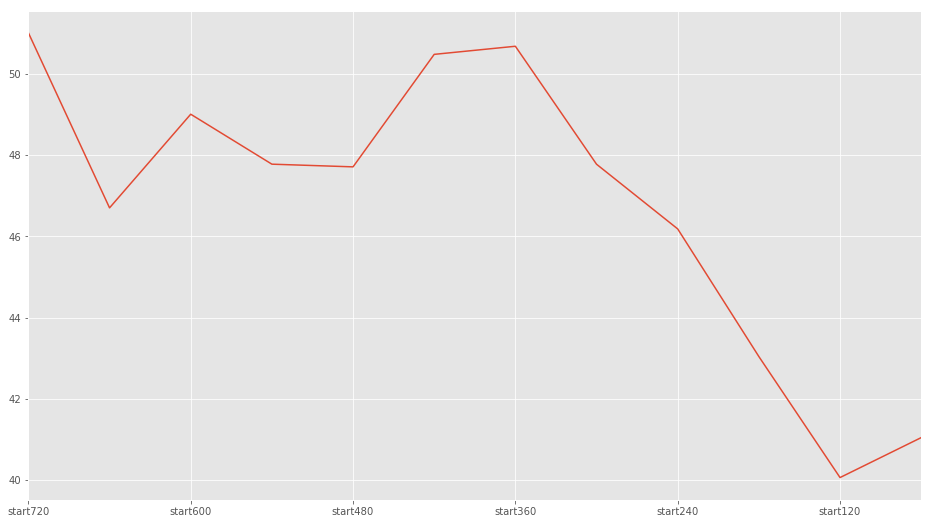

In [61]:
smape_results.mean()[::-1].plot()

In [65]:
smape_results.std(axis=1).mean()

23.137881318902803

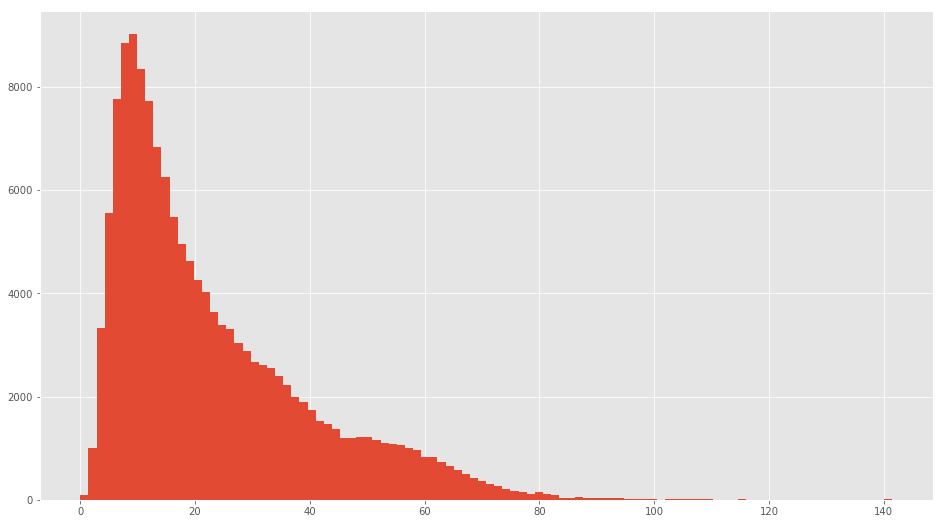

In [66]:
smape_results.std(axis=1).hist(bins=100)

In [70]:
smape_results.iloc[:,:2].std(axis=1).head()

0    4.468476
1    5.962720
2    1.106651
3    1.164040
4    6.950305
dtype: float64

In [72]:
smape_results.iloc[:,:2].head()

,start60,start120
0,32.278432,25.959053
1,42.847863,34.415304
2,64.305367,65.870407
3,32.250349,33.896551
4,48.547274,38.718059


In [ ]:
smape_results.ilocstd(axis=1).hist(bins=100)

In [84]:
train2.iloc[:,train_start-val_length:train_start].head()

,2015-11-10,2015-11-09,2015-11-08,2015-11-07,2015-11-06,2015-11-05,2015-11-04,2015-11-03,2015-11-02,2015-11-01,...,2015-09-21,2015-09-20,2015-09-19,2015-09-18,2015-09-17,2015-09-16,2015-09-15,2015-09-14,2015-09-13,2015-09-12
0,5.0,6.0,10.0,10.0,13.0,16.0,8.0,6.0,6.0,24.0,...,12.0,11.0,9.0,24.0,6.0,16.0,13.0,6.0,10.0,9.0
1,11.0,13.0,18.0,13.0,14.0,33.0,14.0,14.0,14.0,11.0,...,15.0,34.0,16.0,14.0,23.0,20.0,31.0,14.0,34.0,10.0
2,2.0,3.0,6.0,2.0,3.0,2.0,2.0,5.0,2.0,6.0,...,2.0,5.0,2.0,1.0,7.0,6.0,1.0,3.0,1.0,3.0
3,5.0,5.0,7.0,8.0,8.0,9.0,16.0,9.0,8.0,6.0,...,7.0,7.0,19.0,12.0,10.0,9.0,8.0,24.0,7.0,5.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
train2.head()

,2017-08-31,2017-08-30,2017-08-29,2017-08-28,2017-08-27,2017-08-26,2017-08-25,2017-08-24,2017-08-23,2017-08-22,...,2015-07-10,2015-07-09,2015-07-08,2015-07-07,2015-07-06,2015-07-05,2015-07-04,2015-07-03,2015-07-02,2015-07-01
0,21.0,24.0,26.0,44.0,47.0,25.0,23.0,25.0,58.0,37.0,...,24.0,26.0,22.0,9.0,9.0,14.0,13.0,5.0,11.0,18.0
1,25.0,34.0,29.0,32.0,33.0,34.0,31.0,16.0,34.0,14.0,...,4.0,10.0,11.0,22.0,13.0,11.0,18.0,15.0,14.0,11.0
2,9.0,12.0,8.0,12.0,13.0,6.0,8.0,11.0,23.0,6.0,...,4.0,4.0,3.0,0.0,4.0,0.0,1.0,1.0,0.0,1.0
3,15.0,110.0,20.0,20.0,21.0,11.0,17.0,23.0,42.0,21.0,...,16.0,11.0,9.0,14.0,26.0,4.0,94.0,10.0,13.0,35.0
4,24.0,17.0,20.0,29.0,24.0,20.0,22.0,25.0,41.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
def smape_dataframe_full(median_preds, train_start, val_length):
    denominator = train2.iloc[:,train_start-val_length:train_start].add(median_preds, axis=0) / 200
    diff = np.abs(train2.iloc[:,train_start-val_length:train_start].subtract(median_preds, axis=0)) / denominator
    diff[denominator == 0] = 0.0
    return diff

In [91]:
page_df['preds'] = calc_median_preds(60)
ddff = smape_dataframe_full(page_df['preds'], 60, val_length)

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


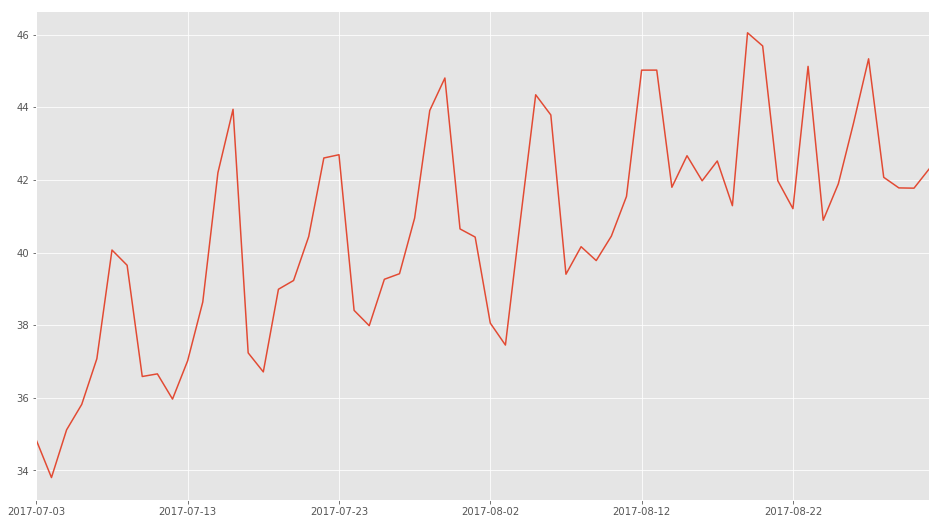

In [97]:
ddff.mean()[::-1].plot()

In [109]:
train2.iloc[:,0:60].std(axis=1) < 10

0         False
1         False
2          True
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12         True
13        False
14        False
15        False
16        False
17         True
18         True
19         True
20        False
21         True
22         True
23        False
24        False
25        False
26        False
27         True
28        False
29         True
          ...  
145033    False
145034     True
145035     True
145036     True
145037     True
145038     True
145039     True
145040     True
145041     True
145042     True
145043     True
145044     True
145045     True
145046     True
145047     True
145048     True
145049     True
145050     True
145051     True
145052     True
145053    False
145054     True
145055     True
145056     True
145057    False
145058     True
145059     True
145060    False
145061     True
145062     True
Length: 145063, dtype: b

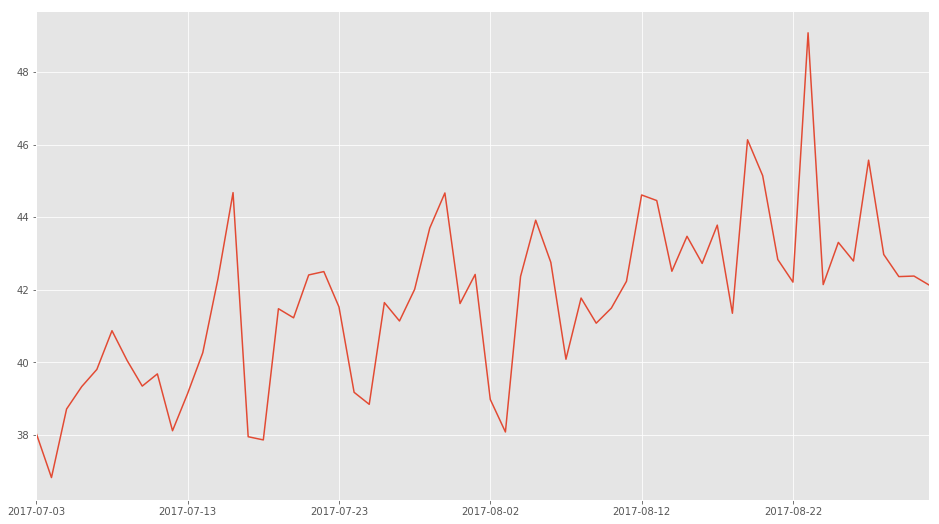

In [112]:
ddff[train2.iloc[:,0:60].std(axis=1) < 100].mean()[::-1].plot()

In [136]:
ddff[train2.iloc[:,0:60].std(axis=1) < 1000].mean()[::-1].mean()

39.926498176581731

In [137]:
ddff[train2.iloc[:,0:60].std(axis=1) > 1000].mean()[::-1].mean()

49.388273784713711

In [117]:
ddff[train2.iloc[:,0:60].std(axis=1) < 100].mean()[::-1].mean()

41.703278044481003

In [118]:
ddff[train2.iloc[:,0:60].std(axis=1) > 100].mean()[::-1].mean()

38.907060960653759

In [119]:
ddff[train2.iloc[:,0:60].std(axis=1) < 20].mean()[::-1].mean()

47.647237255239737

In [120]:
ddff[train2.iloc[:,0:60].std(axis=1) > 20].mean()[::-1].mean()

36.843426895967269

In [121]:
ddff[train2.iloc[:,0:60].std(axis=1) < 10].mean()[::-1].mean()

52.13355529009835

In [122]:
ddff[train2.iloc[:,0:60].std(axis=1) > 10].mean()[::-1].mean()

36.76543209395313

In [123]:
ddff[train2.iloc[:,0:60].std(axis=1) < 5].mean()[::-1].mean()

58.427387839343318

In [124]:
ddff[train2.iloc[:,0:60].std(axis=1) > 5].mean()[::-1].mean()

37.377521639965089

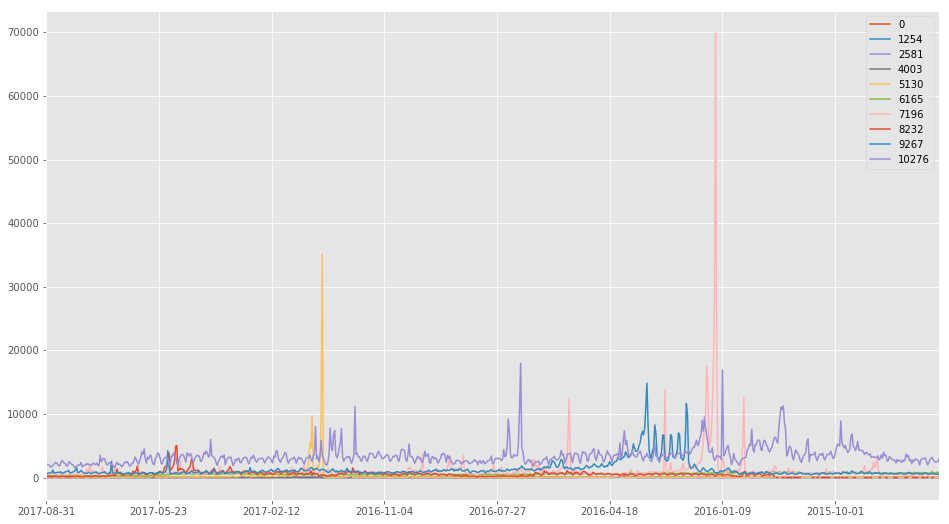

In [132]:
train2[train2.iloc[:,0:60].std(axis=1) > 5].iloc[[i for i in range(0,10000, int(10000/10))],:].T.plot()

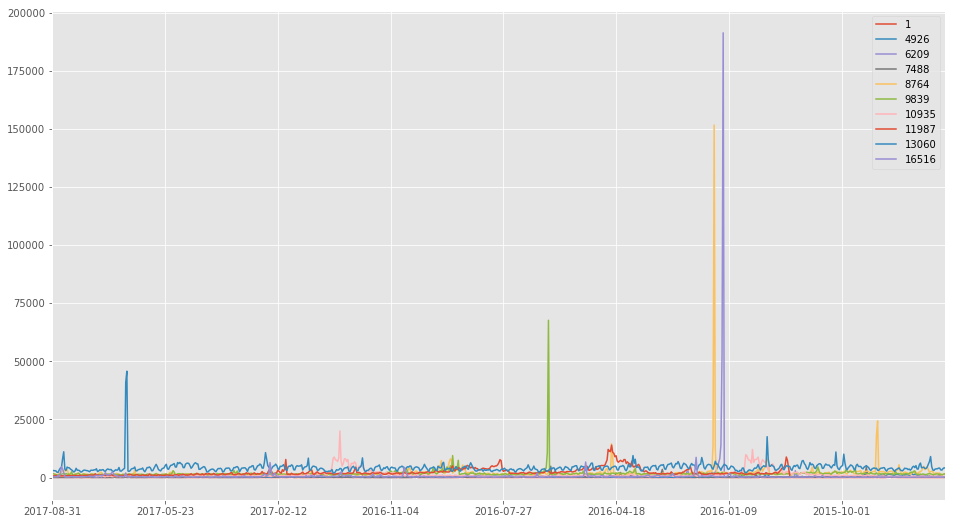

In [133]:
train2[train2.iloc[:,0:60].std(axis=1) > 20].iloc[[i for i in range(0,10000, int(10000/10))],:].T.plot()

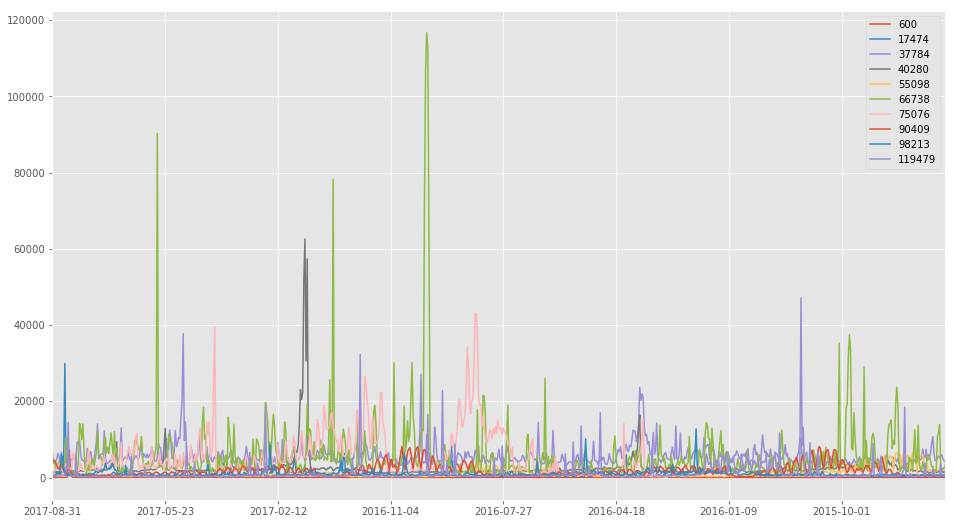

In [135]:
train2[train2.iloc[:,0:60].std(axis=1) > 1000].iloc[[i for i in range(0,10000, int(10000/10))],:].T.plot()

In [ ]:
ddff[train2.iloc[:,0:60].std(axis=1) < 10].mean()[::-1].mean()

In [140]:
ddff[train2.iloc[:,0:60].std(axis=1) < 10].mean(axis=1).mean()

53.057190067079098

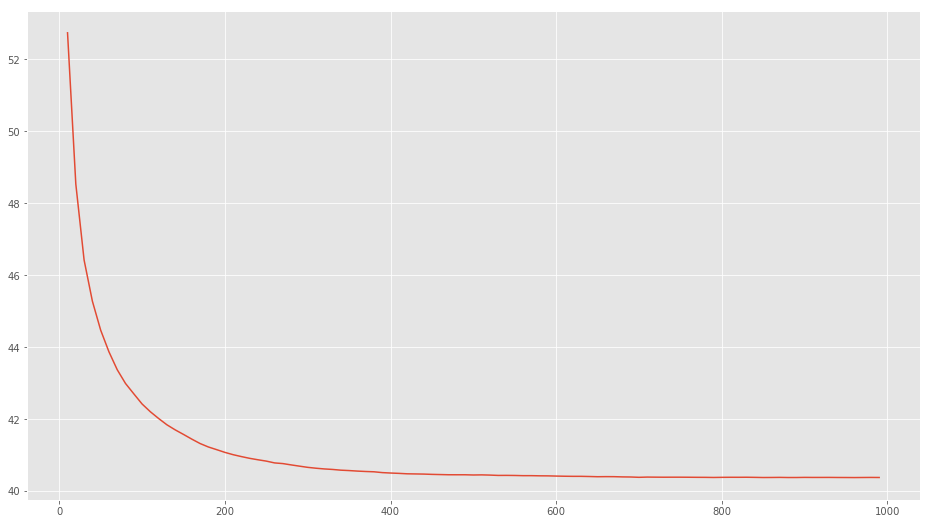

In [143]:
r = range(0, 1000, 10)
plt.plot([i for i in r],[ddff[train2.iloc[:,60:60+49].std(axis=1) < i].mean(axis=1).mean() for i in r])

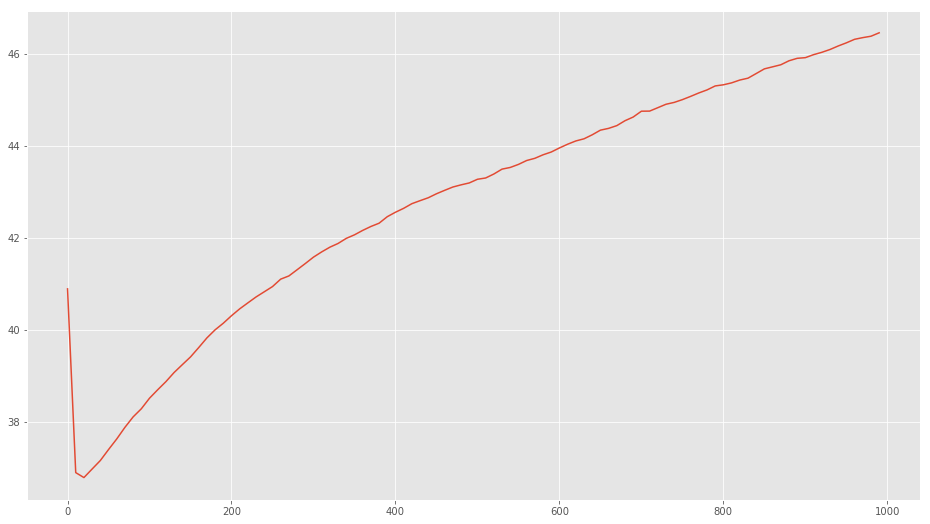

In [144]:
r = range(0, 1000, 10)
plt.plot([i for i in r],[ddff[train2.iloc[:,60:60+49].std(axis=1) > i].mean(axis=1).mean() for i in r])

In [148]:
ddff[train2.iloc[:,60:60+49].std(axis=1) > 10].mean().mean()

36.878882756142168

In [149]:
ddff[train2.iloc[:,60:60+49].std(axis=1) > 20].mean().mean()

36.778402282746406

In [150]:
ddff[train2.iloc[:,60:60+49].std(axis=1) > 40].mean().mean()

37.155995319336519

In [153]:
r = range(10, 40, 2)
zip([ddff[train2.iloc[:,60:60+49].std(axis=1) > i].mean().mean() for i in r], [i for i in r])